In [17]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

In [18]:
DISCOVER_HOST = '10.0.0.4'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [19]:
[session['session_id'] for session in client.list_sessions()['result']]

['experiment_fedavg_LF_05_03',
 'experiment_fedavg_LF_08_00',
 'experiment_fedavg_LF_06_02',
 'experiment_fedavg_LF_07_01']

In [20]:
session_id = input("Provide a session_id: ")

Provide a session_id:  experiment_fedavg_LF_06_02


In [21]:
models = client.list_models(session_id)
# models

In [22]:
num_rounds = models['count']
# num_rounds

In [23]:
# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [24]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'training_loss': json.loads(worker_result['data'])['training_loss'],
            'training_accuracy': json.loads(worker_result['data'])['training_accuracy'],
            'test_loss': json.loads(worker_result['data'])['test_loss'],
            'test_accuracy': json.loads(worker_result['data'])['test_accuracy']
        }
        
        validations.append(validation)
        

In [36]:
validations

[{'model_committed_at': 'Tue, 12 Mar 2024 10:34:40 GMT',
  'session_id': 'experiment_fedavg_LF_06_02',
  'model': '86002146-2843-46eb-b91b-829900a72bfe',
  'client_name': 'benign_client6',
  'client_role': 'WORKER',
  'client_type': 'benign',
  'training_loss': 2.2430756092071533,
  'training_accuracy': 0.30693334341049194,
  'test_loss': 2.2341842651367188,
  'test_accuracy': 0.3343999981880188},
 {'model_committed_at': 'Tue, 12 Mar 2024 10:34:40 GMT',
  'session_id': 'experiment_fedavg_LF_06_02',
  'model': '86002146-2843-46eb-b91b-829900a72bfe',
  'client_name': 'benign_client4',
  'client_role': 'WORKER',
  'client_type': 'benign',
  'training_loss': 2.240349054336548,
  'training_accuracy': 0.30720001459121704,
  'test_loss': 2.2539193630218506,
  'test_accuracy': 0.25040000677108765},
 {'model_committed_at': 'Tue, 12 Mar 2024 10:34:40 GMT',
  'session_id': 'experiment_fedavg_LF_06_02',
  'model': '86002146-2843-46eb-b91b-829900a72bfe',
  'client_name': 'malicious_client1',
  'cli

In [26]:
# set([validation['client_name'] for validation in validations])

In [27]:
# validations

In [28]:
graph_data = {
    'training_loss': {
        client: [] for client in set([validation['client_name'] for validation in validations])
    },
    'training_accuracy': {
        client: [] for client in set([validation['client_name'] for validation in validations])
    },
    'test_loss': {
        client: [] for client in set([validation['client_name'] for validation in validations])
    },
    'test_accuracy': {
        client: [] for client in set([validation['client_name'] for validation in validations])
    },
    'overall_training_loss': [],
    'overall_training_accuracy': [],
    'overall_test_loss': [],
    'overall_test_accuracy': []
}

In [29]:
for validation in validations:
    graph_data['training_loss'][validation['client_name']].append(validation['training_loss'])
    graph_data['training_accuracy'][validation['client_name']].append(validation['training_accuracy'])
    graph_data['test_loss'][validation['client_name']].append(validation['test_loss'])
    graph_data['test_accuracy'][validation['client_name']].append(validation['test_accuracy'])

In [30]:
graph_data['overall_training_loss'] = [np.mean([graph_data['training_loss'][key][i] for key in graph_data['training_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_training_accuracy'] = [np.mean([graph_data['training_accuracy'][key][i] for key in graph_data['training_accuracy'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_loss'] = [np.mean([graph_data['test_loss'][key][i] for key in graph_data['test_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_accuracy'] = [np.mean([graph_data['test_accuracy'][key][i] for key in graph_data['test_accuracy'].keys()]) for i in range(num_rounds)]

In [37]:
graph_data

{'training_loss': {'malicious_client2': [2.23758602142334,
   2.048004150390625,
   1.6971341371536255,
   1.240352988243103,
   0.9273656606674194,
   0.7393156290054321,
   0.6176998615264893,
   0.536371111869812,
   0.47889772057533264,
   0.4366653263568878],
  'benign_client6': [2.2430756092071533,
   2.0612521171569824,
   1.7217119932174683,
   1.2821893692016602,
   0.9800710678100586,
   0.796384871006012,
   0.6758028268814087,
   0.5935521721839905,
   0.5351822376251221,
   0.4918411076068878],
  'benign_client5': [2.242013692855835,
   2.0647103786468506,
   1.7315295934677124,
   1.298010230064392,
   0.9987413287162781,
   0.8152787089347839,
   0.6939236521720886,
   0.6103635430335999,
   0.5512271523475647,
   0.5061161518096924],
  'benign_client2': [2.2401154041290283,
   2.0549120903015137,
   1.7144103050231934,
   1.2787997722625732,
   0.9838654398918152,
   0.8051481246948242,
   0.688293993473053,
   0.6084825992584229,
   0.551973283290863,
   0.509678542613

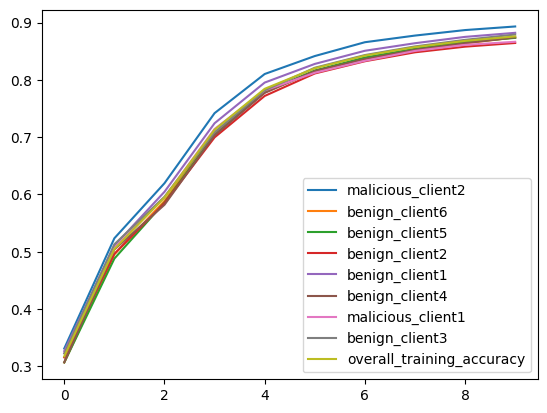

In [32]:
x = range(num_rounds)

for i in range(len(graph_data['training_accuracy'])):
    plt.plot(x, graph_data['training_accuracy'][list(graph_data['training_accuracy'].keys())[i]])
    
plt.plot(x, graph_data['overall_training_accuracy'])
    
plt.legend([label for label in graph_data['training_accuracy'].keys()] + ['overall_training_accuracy'])
plt.show()

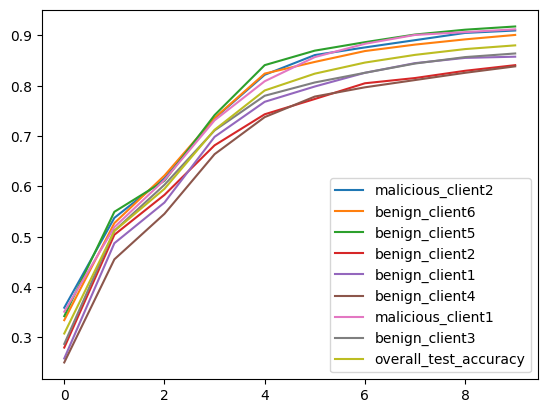

In [33]:
x = range(num_rounds)

for i in range(len(graph_data['test_accuracy'])):
    plt.plot(x, graph_data['test_accuracy'][list(graph_data['test_accuracy'].keys())[i]])
    
plt.plot(x, graph_data['overall_test_accuracy'])
    
plt.legend([label for label in graph_data['test_accuracy'].keys()] + ['overall_test_accuracy'])
plt.show()

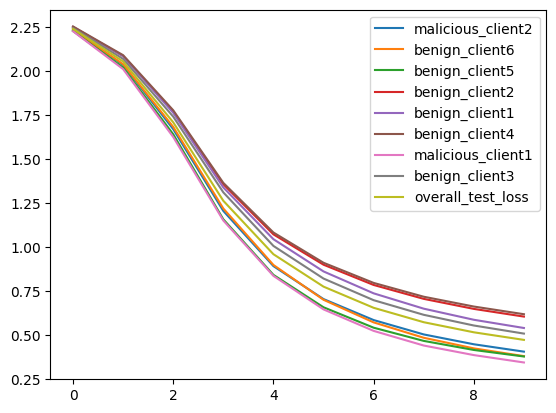

In [34]:
x = range(num_rounds)

for i in range(len(graph_data['test_loss'])):
    plt.plot(x, graph_data['test_loss'][list(graph_data['test_loss'].keys())[i]])
    
plt.plot(x, graph_data['overall_test_loss'])
    
plt.legend([label for label in graph_data['test_loss'].keys()] + ['overall_test_loss'])
plt.show()

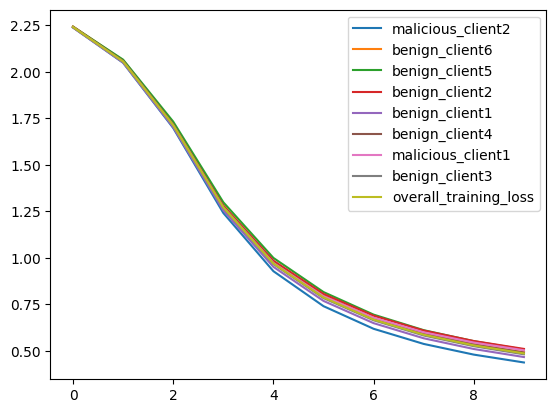

In [35]:
x = range(num_rounds)

for i in range(len(graph_data['training_loss'])):
    plt.plot(x, graph_data['training_loss'][list(graph_data['training_loss'].keys())[i]])
    
plt.plot(x, graph_data['overall_training_loss'])
    
plt.legend([label for label in graph_data['training_loss'].keys()] + ['overall_training_loss'])
plt.show()